# Facial Age Group  Estimation Model

Our Facial Age Group Estimation Model, based on a custom Convolutional Neural Network (CNN) architecture, is subjected to a sample of the multi-experiments we construct. One explores the impact of data augmentation, enhancing the model's exposure to diverse facial features for improved age group predictions. The other investigates the model's inherent capabilities without data augmentation, providing a focused examination of its core strengths in age prediction."

#### and the following are some of the experiments we did:

#### Step 1 - Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import os
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

2023-11-25 01:16:33.624665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Step 2 -  Data Directory and Configuration

In [ ]:
# Define the paths to the train, test, and validation data
train_path = 'Faces_images/train'
test_path = 'Faces_images/test'
valid_path = 'Faces_images/validation'

# Get a list of folders in the train_path and sort them 
folders = sorted(glob(os.path.join(train_path, '*')), key=lambda x: int(os.path.basename(x).split('-')[0]) if '-' in os.path.basename(x) else int(os.path.basename(x).split('+')[0]))

# Define the image size and Batch size
IMAGE_SIZE = [224, 224]
batch_size = 32

# Define the class labels 
class_labels = ['0-3', '4+', '9+', '12+', '17+']

## Experiment 1: without data augmentation:

#### Start with Step 3 Image Data Normalization and Loading for Training, Validation, and Test Sets 

In [ ]:
# Define the batch size
batch_size = 32

# Pixel Value Normalization , it rescales the pixel values so that they fall within the range [0, 1].
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators for loading data into batches
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

validation_set = validation_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

Found 13618 images belonging to 5 classes.
Found 1703 images belonging to 5 classes.
Found 1706 images belonging to 5 classes.


#### Step 4 - Building the CNN Model and compiling it and Early Stopping and Learning Rate Schedule

In [ ]:
# Building the model
input_layer = Input(shape=(224, 224, 3))

# Convolutional Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten and Fully Connected Layers with Dropout
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(5, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compiling the Model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Early Stopping and Learning Rate Schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 112, 112, 64)     256 

#### Step 5 - Training the Model

In [ ]:
# Train the model
epochs = 30  
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    validation_data=validation_set,
    validation_steps=len(validation_set),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2023-11-23 23:53:17.256788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - ETA: 0s - loss: 4.3661 - accuracy: 0.4070

2023-11-23 23:57:29.666329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - 263s 613ms/step - loss: 4.3661 - accuracy: 0.4070 - val_loss: 3.2954 - val_accuracy: 0.3048 - lr: 0.0010
Epoch 2/30
426/426 [==============================] - 261s 612ms/step - loss: 3.0804 - accuracy: 0.4800 - val_loss: 3.4109 - val_accuracy: 0.4398 - lr: 0.0010
Epoch 3/30
426/426 [==============================] - 260s 610ms/step - loss: 3.3388 - accuracy: 0.4905 - val_loss: 5.8008 - val_accuracy: 0.3876 - lr: 0.0010
Epoch 4/30
426/426 [==============================] - 2075s 5s/step - loss: 3.8038 - accuracy: 0.5667 - val_loss: 2.9235 - val_accuracy: 0.5948 - lr: 1.0000e-04
Epoch 5/30
426/426 [==============================] - 898s 2s/step - loss: 2.4998 - accuracy: 0.6074 - val_loss: 2.1542 - val_accuracy: 0.6230 - lr: 1.0000e-04
Epoch 6/30
426/426 [==============================] - 288s 675ms/step - loss: 1.9178 - accuracy: 0.6270 - val_loss: 1.7263 - val_accuracy: 0.6453 - lr: 1.0000e-04
Epoch 7/30
426/426 [==============================

#### The training process stops using the early stopping technique since there is no improvement in the validation loss for 5 consecutive epochs.


#### Step 6 - Evaluating the Model

In [ ]:
# Evaluate the Model on the Test Set
test_loss, test_acc = model.evaluate(test_set, steps=len(test_set))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

2023-11-24 03:49:42.294905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


54/54 [==============================] - 10s 186ms/step - loss: 1.0808 - accuracy: 0.6436
Test Loss: 1.080791711807251
Test Accuracy: 0.6436107754707336


##### Confusion Matrix Visualization and Model Performance Report

1/1 [==============================] - 0s 128ms/step


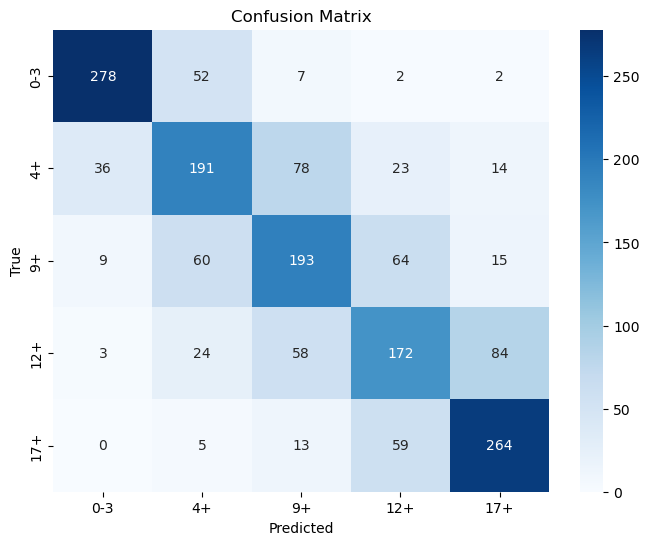

              precision    recall  f1-score   support

         0-3       0.85      0.82      0.83       341
          4+       0.58      0.56      0.57       342
          9+       0.55      0.57      0.56       341
         12+       0.54      0.50      0.52       341
         17+       0.70      0.77      0.73       341

    accuracy                           0.64      1706
   macro avg       0.64      0.64      0.64      1706
weighted avg       0.64      0.64      0.64      1706



In [ ]:
# Model Evaluation and Confusion Matrix

# Initialize variables to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test set and make predictions
for i in range(len(test_set)):
    images, labels = test_set[i]
    true_labels.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create the confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

#### Step 7 - Plotting Loss and Accuracy Curves

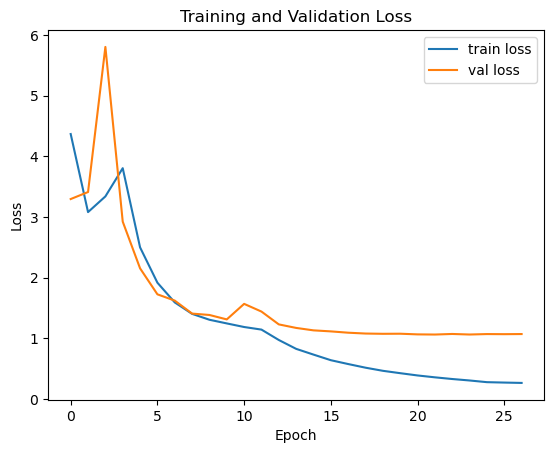

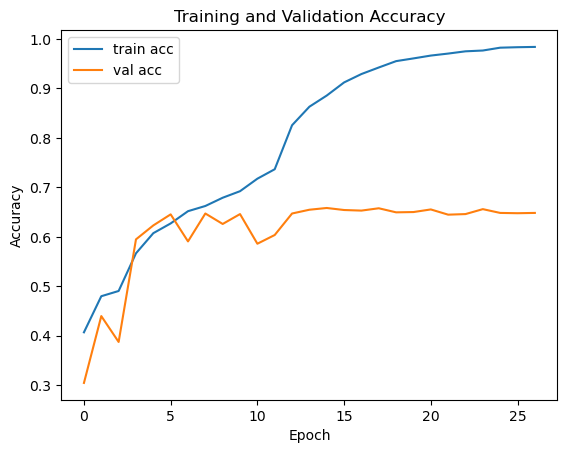

In [ ]:
# Plotting Loss Curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting Accuracy Curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

#### an overfitting without the data augmention

#### Step 8 and the last one- Saving the Model

In [ ]:
# Saving the Model if needed
model.save('AgeEstimation_CNN_E1.h5')

## Experiment 2: with data augmentaion

#### Start with Step 3: Image Data Augmentation and Loading for Training, Validation, and Test Sets since Steps 1 and 2 are the same.

In [ ]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom transformation
    horizontal_flip=True  # Horizontal flip
)

# Data Augmentation for Validation Set (only normalization, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data Augmentation for Test Set (only normalization, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


# Data Generators for loading data into batches
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

validation_set = validation_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

Found 13618 images belonging to 5 classes.
Found 1703 images belonging to 5 classes.
Found 1706 images belonging to 5 classes.


#### Step 4 - Building the CNN Model and compiling it and Early Stopping and Learning Rate Schedule

In [ ]:

# Building the model
input_layer = Input(shape=(224, 224, 3))

# Convolutional Block 1
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional Block 3
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten and Fully Connected Layers with Dropout
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(5, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compiling the Model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Early Stopping and Learning Rate Schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128   

#### Step 5 - Training the Model

In [ ]:
# Train the model
epochs = 30
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    validation_data=validation_set,
    validation_steps=len(validation_set),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2023-11-25 01:16:39.455646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - ETA: 0s - loss: 2.6451 - accuracy: 0.4016

2023-11-25 01:19:16.718203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - 161s 375ms/step - loss: 2.6451 - accuracy: 0.4016 - val_loss: 2.2479 - val_accuracy: 0.3376 - lr: 0.0010
Epoch 2/30
426/426 [==============================] - 160s 375ms/step - loss: 1.9493 - accuracy: 0.4736 - val_loss: 3.3336 - val_accuracy: 0.2126 - lr: 0.0010
Epoch 3/30
426/426 [==============================] - 145s 339ms/step - loss: 1.7860 - accuracy: 0.5071 - val_loss: 1.6273 - val_accuracy: 0.5596 - lr: 0.0010
Epoch 4/30
426/426 [==============================] - 145s 339ms/step - loss: 1.7342 - accuracy: 0.5046 - val_loss: 2.7899 - val_accuracy: 0.3987 - lr: 0.0010
Epoch 5/30
426/426 [==============================] - 146s 342ms/step - loss: 2.0680 - accuracy: 0.4981 - val_loss: 1.9445 - val_accuracy: 0.4234 - lr: 0.0010
Epoch 6/30
426/426 [==============================] - 145s 339ms/step - loss: 1.4151 - accuracy: 0.5709 - val_loss: 1.2280 - val_accuracy: 0.6078 - lr: 1.0000e-04
Epoch 7/30
426/426 [==============================] -

#### Step 6 - Evaluating the Model

In [ ]:

# Evaluate the Model on the Test Set
test_loss, test_acc = model.evaluate(test_set, steps=len(test_set))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

2023-11-25 02:35:51.187190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


54/54 [==============================] - 4s 74ms/step - loss: 0.8008 - accuracy: 0.7069
Test Loss: 0.8008002638816833
Test Accuracy: 0.7069167494773865


##### Confusion Matrix Visualization and Model Performance Report

1/1 [==============================] - 0s 47ms/step


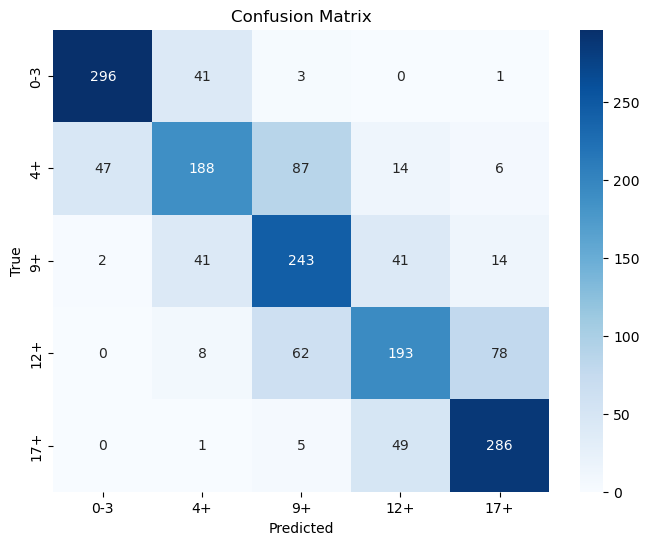

              precision    recall  f1-score   support

         0-3       0.86      0.87      0.86       341
          4+       0.67      0.55      0.61       342
          9+       0.61      0.71      0.66       341
         12+       0.65      0.57      0.61       341
         17+       0.74      0.84      0.79       341

    accuracy                           0.71      1706
   macro avg       0.71      0.71      0.70      1706
weighted avg       0.71      0.71      0.70      1706



In [ ]:
# Initialize variables to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test set and make predictions
for i in range(len(test_set)):
    images, labels = test_set[i]
    true_labels.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create the confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

#### Step 7 - Plotting Loss and Accuracy Curves

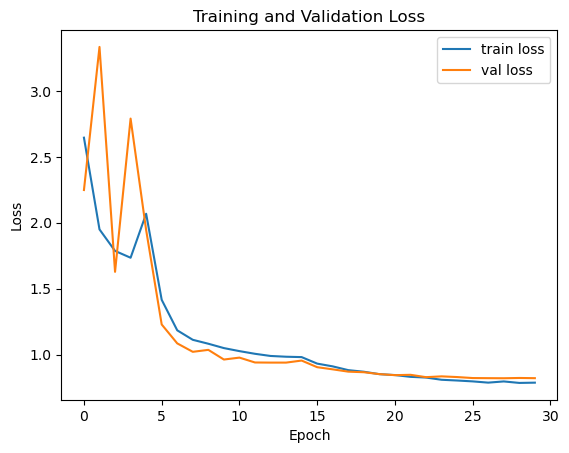

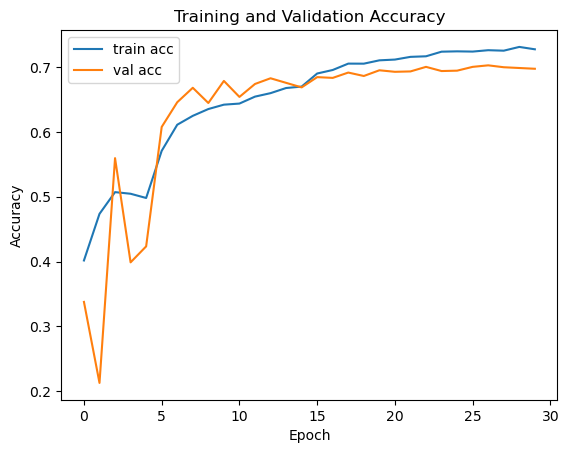

In [ ]:
# Plotting Loss Curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting Accuracy Curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

#### Step 8 and the last one- Saving the Model

In [ ]:
# Saving the Model if needed to use
model.save('AgeEstimation_CNN_E_2.h5')

#### Results: These are samples from continuous model experimentation and optimization, with the goal of getting the best outcomes. The finalized model, featured on the Game Geek website, represents the approved version.